## Extrinsic calibration in `Real-world`

### Real-sense libraries

In [1]:
import pyrealsense2 as rs
import numpy as np
import matplotlib.pyplot as plt
import cv2

import json
import copy

import sys
sys.path.append("..")
from utils.utils_cali import *

### setup camera

##### just taking picture

Frames Captured: Clean image
Frames Captured: Yellowish image


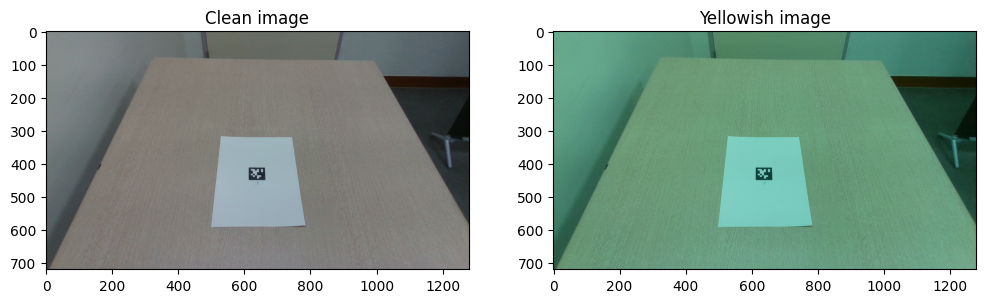

In [95]:
import pyrealsense2 as rs
import numpy as np
import matplotlib.pyplot as plt

# Setup:
pipe = rs.pipeline()
cfg = rs.config()
profile = pipe.start(cfg)

for x in range(100):
  pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
rgb_image = frameset.get_color_frame()
depth_image = frameset.get_depth_frame()

# Cleanup:
pipe.stop()
print("Frames Captured: Clean image")
rgb_image = np.asanyarray(rgb_image.get_data())
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.subplot(1,2,1)
plt.title("Clean image")
plt.imshow(rgb_image)
# plt.show()

# Setup:
pipe = rs.pipeline()
cfg = rs.config()
profile = pipe.start(cfg)
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
rgb_image = frameset.get_color_frame()
depth_image = frameset.get_depth_frame()

# Cleanup:
pipe.stop()
print("Frames Captured: Yellowish image")
rgb_image = np.asanyarray(rgb_image.get_data())
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.subplot(1,2,2)
plt.title("Yellowish image")
plt.imshow(rgb_image)
plt.show()

#### AprilTag pose estimation

W:  1280
H:  720
FPS:  30
Depth Scale is: 0.0010 m


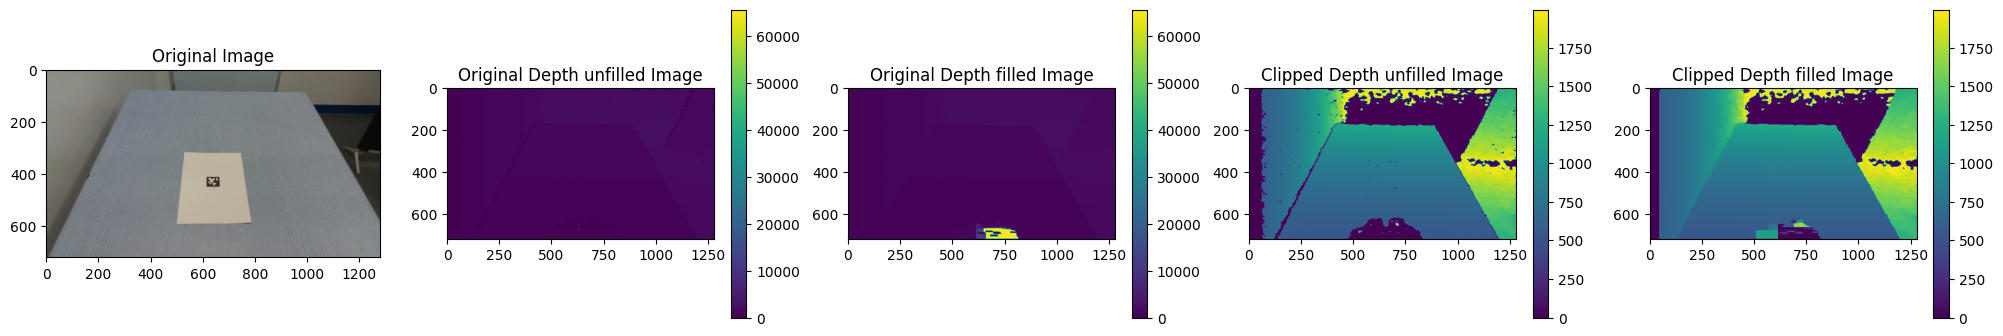

Frames Captured


In [96]:
# Setup:
pipe = rs.pipeline()
config = rs.config()

# setting pre-defined camera parameters.
jsonObj = json.load(open("../cam_setting.json"))
json_string= str(jsonObj).replace("'", '\"')

print("W: ", int(jsonObj["viewer"]['stream-width']))
print("H: ", int(jsonObj["viewer"]['stream-height']))
print("FPS: ", int(jsonObj["viewer"]['stream-fps']))

config.enable_stream(rs.stream.depth, int(jsonObj["viewer"]['stream-width']), int(jsonObj["viewer"]['stream-height']), rs.format.z16, int(jsonObj["viewer"]['stream-fps']))
config.enable_stream(rs.stream.color, int(jsonObj["viewer"]['stream-width']), int(jsonObj["viewer"]['stream-height']), rs.format.bgr8, int(jsonObj["viewer"]['stream-fps']))

cfg = pipe.start(config)
# cfg = pipe.start() # Start pipeline and get the configuration it found

# prevent yellowish image
for x in range(100):
  pipe.wait_for_frames()

# profile = pipe.start(cfg)
profile = cfg.get_stream(rs.stream.depth) # Fetch stream profile for depth stream
intrinsic_matrix = profile.as_video_stream_profile().get_intrinsics() # Downcast to video_stream_profile and fetch intrinsics
# print(dir(cfg.get_device()))
depth_sensor = cfg.get_device().first_depth_sensor()        # depth sensor에 대한 것들을 얻자
depth_scale = depth_sensor.get_depth_scale()                # 깊이 센서의 깊이 스케일 얻음
print(f"Depth Scale is: {depth_scale:.4f} m")

for x in range(5):
  pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
rgb_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# filling depth imgage.
spatial = rs.spatial_filter()
spatial.set_option(rs.option.holes_fill, 3)
filtered_depth = spatial.process(depth_frame)

hole_filling = rs.hole_filling_filter()
filled_depth = hole_filling.process(filtered_depth)

depth_image_unfilled = np.asanyarray(depth_frame.get_data())
depth_image_filled = np.asanyarray(filled_depth.get_data())
color_image = np.asanyarray(rgb_frame.get_data())

# clipping depth image.
zero_padding = 0
clipping_distance_in_meters = 2    # 1 meter, 클리핑할 영역을 1m로 설정
clipping_distance = clipping_distance_in_meters / depth_scale   #스케일에 따른 클리핑 거리
depth_clipped_unfilled = np.where((depth_image_unfilled > clipping_distance) | (depth_image_unfilled <= 0), zero_padding, depth_image_unfilled)
depth_clipped_filled = np.where((depth_image_filled > clipping_distance) | (depth_image_filled <= 0), zero_padding, depth_image_filled)

# 3D image estimation.
img_xyz_unfilled = compute_xyz(depth_image_unfilled, camera_info=intrinsic_matrix)
img_xyz_filled = compute_xyz(depth_image_filled, camera_info=intrinsic_matrix)
img_xyz_clipped_unfilled = compute_xyz(depth_clipped_unfilled, camera_info=intrinsic_matrix)
img_xyz_clipped_filled = compute_xyz(depth_clipped_filled, camera_info=intrinsic_matrix)

img_copy = copy.deepcopy(color_image)
T_april, img_pose = get_apriltag_pose(img_copy, depth_image_unfilled, intrinsic_matrix=intrinsic_matrix, tag_size=0.008, verbose_bbox=False, verbose_pose=True)


plt.figure(figsize=(25,4))
plt.subplot(1,5,1)
plt.title("Original Image")
plt.imshow(color_image)
# plt.show()

plt.subplot(1,5,2)
plt.title("Original Depth unfilled Image")
plt.imshow(depth_image_unfilled)
plt.colorbar()
# plt.show()

plt.subplot(1,5,3)
plt.title("Original Depth filled Image")
plt.imshow(depth_image_filled)
plt.colorbar()
# plt.show()

plt.subplot(1,5,4)
plt.title("Clipped Depth unfilled Image")
plt.imshow(depth_clipped_unfilled)
plt.colorbar()
# plt.show()

plt.subplot(1,5,5)
plt.title("Clipped Depth filled Image")
plt.imshow(depth_clipped_filled)
plt.colorbar()
plt.show()

# Cleanup:
pipe.stop()
print("Frames Captured")

W:  1280
H:  720
FPS:  30
Depth Scale is: 0.0010 m


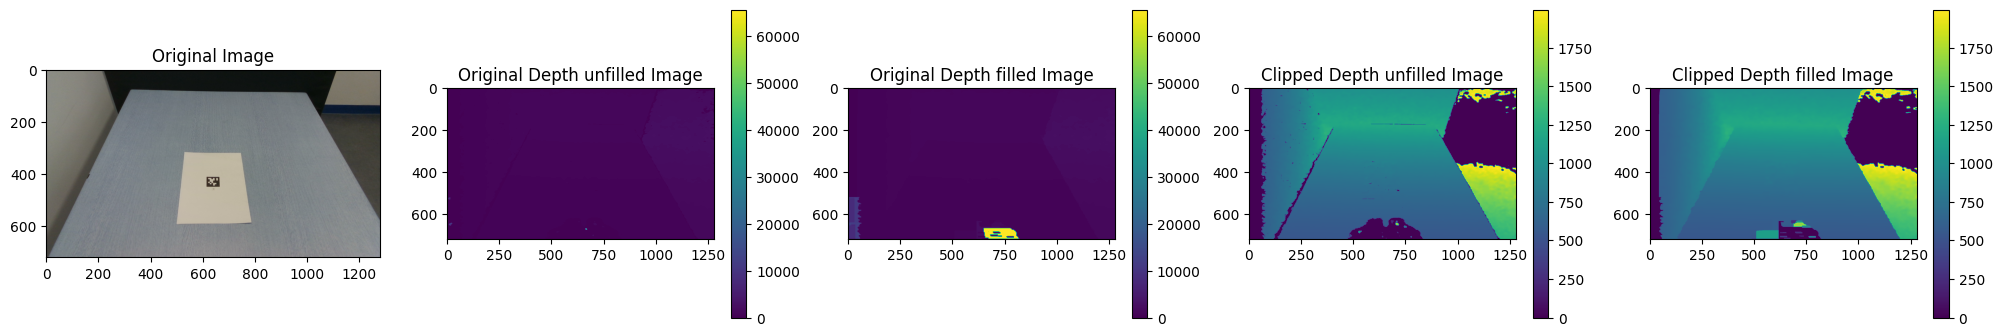

Frames Captured


In [97]:
# Setup:
pipe = rs.pipeline()
config = rs.config()

# setting pre-defined camera parameters.
jsonObj = json.load(open("../cam_setting.json"))
json_string= str(jsonObj).replace("'", '\"')

print("W: ", int(jsonObj["viewer"]['stream-width']))
print("H: ", int(jsonObj["viewer"]['stream-height']))
print("FPS: ", int(jsonObj["viewer"]['stream-fps']))

config.enable_stream(rs.stream.depth, int(jsonObj["viewer"]['stream-width']), int(jsonObj["viewer"]['stream-height']), rs.format.z16, int(jsonObj["viewer"]['stream-fps']))
config.enable_stream(rs.stream.color, int(jsonObj["viewer"]['stream-width']), int(jsonObj["viewer"]['stream-height']), rs.format.bgr8, int(jsonObj["viewer"]['stream-fps']))

cfg = pipe.start(config)
# cfg = pipe.start() # Start pipeline and get the configuration it found

# prevent yellowish image
for x in range(100):
  pipe.wait_for_frames()

# profile = pipe.start(cfg)
profile = cfg.get_stream(rs.stream.depth) # Fetch stream profile for depth stream
intrinsic_matrix = profile.as_video_stream_profile().get_intrinsics() # Downcast to video_stream_profile and fetch intrinsics
# print(dir(cfg.get_device()))
depth_sensor = cfg.get_device().first_depth_sensor()        # depth sensor에 대한 것들을 얻자
depth_scale = depth_sensor.get_depth_scale()                # 깊이 센서의 깊이 스케일 얻음
print(f"Depth Scale is: {depth_scale:.4f} m")

for x in range(5):
  pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
rgb_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# filling depth imgage.
spatial = rs.spatial_filter()
spatial.set_option(rs.option.holes_fill, 3)
filtered_depth = spatial.process(depth_frame)

hole_filling = rs.hole_filling_filter()
filled_depth = hole_filling.process(filtered_depth)

depth_image_unfilled = np.asanyarray(depth_frame.get_data())
depth_image_filled = np.asanyarray(filled_depth.get_data())
color_image = np.asanyarray(rgb_frame.get_data())

# clipping depth image.
zero_padding = 0
clipping_distance_in_meters = 2    # 1 meter, 클리핑할 영역을 1m로 설정
clipping_distance = clipping_distance_in_meters / depth_scale   #스케일에 따른 클리핑 거리
depth_clipped_unfilled = np.where((depth_image_unfilled > clipping_distance) | (depth_image_unfilled <= 0), zero_padding, depth_image_unfilled)
depth_clipped_filled = np.where((depth_image_filled > clipping_distance) | (depth_image_filled <= 0), zero_padding, depth_image_filled)

# 3D image estimation.
img_xyz_unfilled = compute_xyz(depth_image_unfilled, camera_info=intrinsic_matrix)
img_xyz_filled = compute_xyz(depth_image_filled, camera_info=intrinsic_matrix)
img_xyz_clipped_unfilled = compute_xyz(depth_clipped_unfilled, camera_info=intrinsic_matrix)
img_xyz_clipped_filled = compute_xyz(depth_clipped_filled, camera_info=intrinsic_matrix)

img_copy = copy.deepcopy(color_image)
T_april, img_pose = get_apriltag_pose(img_copy, depth_image_unfilled, intrinsic_matrix=intrinsic_matrix, tag_size=0.008, verbose_bbox=False, verbose_pose=True)


plt.figure(figsize=(25,4))
plt.subplot(1,5,1)
plt.title("Original Image")
plt.imshow(color_image)
# plt.show()

plt.subplot(1,5,2)
plt.title("Original Depth unfilled Image")
plt.imshow(depth_image_unfilled)
plt.colorbar()
# plt.show()

plt.subplot(1,5,3)
plt.title("Original Depth filled Image")
plt.imshow(depth_image_filled)
plt.colorbar()
# plt.show()

plt.subplot(1,5,4)
plt.title("Clipped Depth unfilled Image")
plt.imshow(depth_clipped_unfilled)
plt.colorbar()
# plt.show()

plt.subplot(1,5,5)
plt.title("Clipped Depth filled Image")
plt.imshow(depth_clipped_filled)
plt.colorbar()
plt.show()

# Cleanup:
pipe.stop()
print("Frames Captured")

W:  1280
H:  720
FPS:  30
Depth Scale is: 0.0010 m


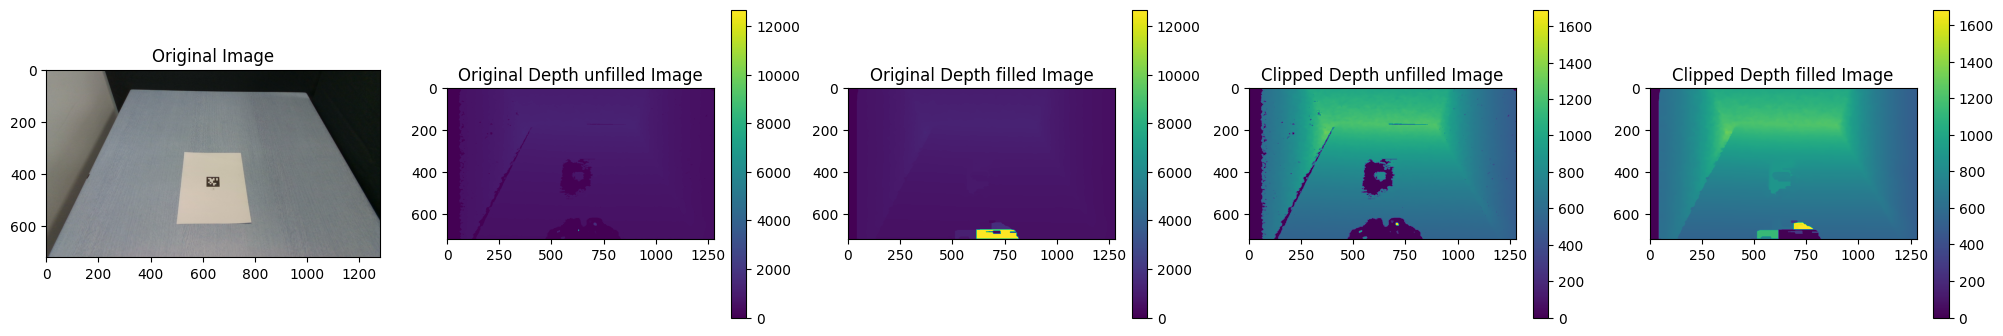

Frames Captured


In [2]:
# Setup:
pipe = rs.pipeline()
config = rs.config()

# setting pre-defined camera parameters.
jsonObj = json.load(open("../cam_setting.json"))
json_string= str(jsonObj).replace("'", '\"')

print("W: ", int(jsonObj["viewer"]['stream-width']))
print("H: ", int(jsonObj["viewer"]['stream-height']))
print("FPS: ", int(jsonObj["viewer"]['stream-fps']))

config.enable_stream(rs.stream.depth, int(jsonObj["viewer"]['stream-width']), int(jsonObj["viewer"]['stream-height']), rs.format.z16, int(jsonObj["viewer"]['stream-fps']))
config.enable_stream(rs.stream.color, int(jsonObj["viewer"]['stream-width']), int(jsonObj["viewer"]['stream-height']), rs.format.bgr8, int(jsonObj["viewer"]['stream-fps']))

cfg = pipe.start(config)
# cfg = pipe.start() # Start pipeline and get the configuration it found

# prevent yellowish image
for x in range(100):
  pipe.wait_for_frames()

# profile = pipe.start(cfg)
profile = cfg.get_stream(rs.stream.depth) # Fetch stream profile for depth stream
intrinsic_matrix = profile.as_video_stream_profile().get_intrinsics() # Downcast to video_stream_profile and fetch intrinsics
# print(dir(cfg.get_device()))
depth_sensor = cfg.get_device().first_depth_sensor()        # depth sensor에 대한 것들을 얻자
depth_scale = depth_sensor.get_depth_scale()                # 깊이 센서의 깊이 스케일 얻음
print(f"Depth Scale is: {depth_scale:.4f} m")

for x in range(5):
  pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
rgb_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# filling depth imgage.
spatial = rs.spatial_filter()
spatial.set_option(rs.option.holes_fill, 3)
filtered_depth = spatial.process(depth_frame)

hole_filling = rs.hole_filling_filter()
filled_depth = hole_filling.process(filtered_depth)

depth_image_unfilled = np.asanyarray(depth_frame.get_data())
depth_image_filled = np.asanyarray(filled_depth.get_data())
color_image = np.asanyarray(rgb_frame.get_data())

# clipping depth image.
zero_padding = 0
clipping_distance_in_meters = 2    # 1 meter, 클리핑할 영역을 1m로 설정
clipping_distance = clipping_distance_in_meters / depth_scale   #스케일에 따른 클리핑 거리
depth_clipped_unfilled = np.where((depth_image_unfilled > clipping_distance) | (depth_image_unfilled <= 0), zero_padding, depth_image_unfilled)
depth_clipped_filled = np.where((depth_image_filled > clipping_distance) | (depth_image_filled <= 0), zero_padding, depth_image_filled)

# 3D image estimation.
img_xyz_unfilled = compute_xyz(depth_image_unfilled, camera_info=intrinsic_matrix)
img_xyz_filled = compute_xyz(depth_image_filled, camera_info=intrinsic_matrix)
img_xyz_clipped_unfilled = compute_xyz(depth_clipped_unfilled, camera_info=intrinsic_matrix)
img_xyz_clipped_filled = compute_xyz(depth_clipped_filled, camera_info=intrinsic_matrix)

img_copy = copy.deepcopy(color_image)
T_april, img_pose = get_apriltag_pose(img_copy, depth_image_unfilled, intrinsic_matrix=intrinsic_matrix, tag_size=0.008, verbose_bbox=False, verbose_pose=True)


plt.figure(figsize=(25,4))
plt.subplot(1,5,1)
plt.title("Original Image")
plt.imshow(color_image)
# plt.show()

plt.subplot(1,5,2)
plt.title("Original Depth unfilled Image")
plt.imshow(depth_image_unfilled)
plt.colorbar()
# plt.show()

plt.subplot(1,5,3)
plt.title("Original Depth filled Image")
plt.imshow(depth_image_filled)
plt.colorbar()
# plt.show()

plt.subplot(1,5,4)
plt.title("Clipped Depth unfilled Image")
plt.imshow(depth_clipped_unfilled)
plt.colorbar()
# plt.show()

plt.subplot(1,5,5)
plt.title("Clipped Depth filled Image")
plt.imshow(depth_clipped_filled)
plt.colorbar()
plt.show()

# Cleanup:
pipe.stop()
print("Frames Captured")

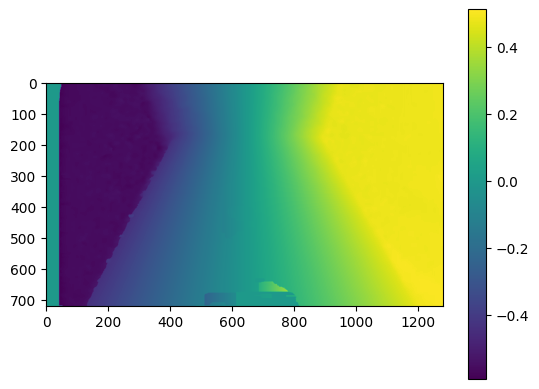

In [3]:
plt.imshow(img_xyz_clipped_filled[:,:,1])
plt.colorbar()

In [4]:
img_copy = copy.deepcopy(color_image)
T_tag, img_pose = get_apriltag_pose(img_copy, depth_image_unfilled, intrinsic_matrix=intrinsic_matrix, tag_size=0.008, verbose_bbox=False, verbose_pose=True)


In [5]:
print(T_tag)

[[ 0.99922821  0.02470571 -0.03053864 -0.08468157]
 [ 0.00542555  0.68318781  0.73022256 -0.00963622]
 [ 0.0389043  -0.72982467  0.68252649  0.77      ]
 [ 0.          0.          0.          1.        ]]


### UR5 libraries

In [6]:
from kinematics.class_structure import *

file_name = "../../urdf/ur5e_onrobot.urdf"
chain = CHAIN(file_name=file_name, base_offset=[0.18,0,0.79], verbose=False)
chain.add_joi_to_robot()
chain.add_joi_to_robot()
chain.add_link_to_robot()
chain.fk_chain(1)


In [7]:
import sys 
sys.path.append("..")
import cv2 
from get_rostopic import RealsenseD435i
import numpy as np 
import rospy 
import matplotlib.pyplot as plt 
from utils.utils_pcl import *
from utils.utils_pointcloud import * 
print("Done.")

import rospy 
import time 
import numpy as np 
import message_filters
from sensor_msgs.msg import JointState

class UR_Test():
    def __init__(self):
        self.tick = 0
        self.joint_list = None 
        self.joint_sub = rospy.Subscriber('/joint_states', JointState, self.joint_callback) 

        tic_temp=0 

        while self.tick<2: 
            time.sleep(1e-3)
            tic_temp=tic_temp+1

            if tic_temp>5000: 
                print ("[ERROR] GET JOINTS")
                break 
            
    def joint_callback(self, joint_msg):
        """
            Get joint values about each joint.
        """
        self.tick+=1 
        self.joint_list = joint_msg 

    # def fk_chain(self, idx_to):
    #     # self.joint_list = 
        
    #     if idx_to == 0:
    #         pass
    #     elif idx_to != 0:
    #         link_mother =  self.joint

    #     return 0

Done.


#### get `joint value` in real-time

In [10]:
rospy.init_node('test')
ur_test = UR_Test()

print(ur_test.joint_list.position)
joint_value = ur_test.joint_list.position   # tuple form

(-1.57098895708193, -2.3194996319212855, 2.144972626362936, 1.728928490276001, 0.7871789932250977, -1.5711692015277308)


### update q_chain

In [11]:
def update_q_chain(robot_jc, q_list, ctrl_joint):
    for idx in range(len(robot_jc)):
        if idx < ctrl_joint:
            robot_jc[idx].q = q_list[idx]

In [13]:
# joint_value = [-1.5701611677752894, -2.317308088342184, 2.151837174092428,
#                 1.7310170370289306, 0.7755656242370605, -1.5670517126666468]

joint_value = ur_test.joint_list.position   # tuple form
joint_value_list = list(joint_value)        # list form

q_list = [0]    # Add for Origin base joint.
q_list = q_list + joint_value_list  # Sequential joint values: 7

# Update q_chain
ctrl_joint_num = 6
update_q_chain(chain.joint, q_list, ctrl_joint_num)
chain.fk_chain(1)   # forward kinematic.

p_list     = get_p_chain(chain.joint)
R_list     = get_R_chain(chain.joint)

print(p_list[:6])
print(R_list[:6])

T_wrist3 = cv2.hconcat((R_list[6], p_list[6]))
T_wrist3 = np.vstack((T_wrist3, np.array([0,0,0,1])))
print(T_wrist3)

[[ 1.80000000e-01  0.00000000e+00  7.90000000e-01]
 [ 1.80000000e-01  0.00000000e+00  9.53000000e-01]
 [ 3.17999997e-01 -3.00047628e-05  9.53000000e-01]
 [ 1.87062902e-01  2.89302605e-01  1.26433281e+00]
 [ 1.86978966e-01 -9.67423958e-02  1.33240079e+00]
 [ 3.13978963e-01 -9.67700089e-02  1.33240079e+00]]
[array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), array([[-2.17425818e-04,  9.99999976e-01,  0.00000000e+00],
       [-9.99999976e-01, -2.17425818e-04,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]), array([[-1.59274802e-04,  9.99999976e-01,  1.48005148e-04],
       [-7.32547770e-01, -2.17425818e-04,  6.80715592e-01],
       [ 6.80715608e-01,  0.00000000e+00,  7.32547787e-01]]), array([[-3.77544316e-05,  9.99999976e-01, -2.14122836e-04],
       [-1.73642813e-01, -2.17425818e-04, -9.84808675e-01],
       [-9.84808698e-01,  0.00000000e+00,  1.73642818e-01]]), array([[ 3.56984089e-06,  9.99999976e-01,  2.17396510e-04],
       [ 1.64186611e-

##### forward kinematic

In [62]:
chain.joint[6].name

'wrist_3_joint'

In [17]:
for i in range(len(q_list)):
    chain.joint[i].q = q_list[i]
    print(f"the {chain.joint[i].name}'s q value is : {chain.joint[i].q}")

# forward kinematics: correspond to each joint values.
chain.fk_chain(1)

p_eef = chain.joint[6].p
R_eef = chain.joint[6].R
# print(p_eef)

T_eef = cv2.hconcat((R_eef, p_eef))
T_eef = np.vstack((T_eef, np.array([0,0,0,1])))
print(T_eef)

the base_joint's q value is : 0
the shoulder_pan_joint's q value is : -1.5710137526141565
the shoulder_lift_joint's q value is : -2.3195353947081507
the elbow_joint's q value is : 2.145007912312643
the wrist_1_joint's q value is : 1.7289044099995117
the wrist_2_joint's q value is : 0.7872028350830078
the wrist_3_joint's q value is : -1.571193043385641
[[-6.36312759e-05  7.05826989e-01 -7.08384258e-01  3.14000703e-01]
 [ 9.99860566e-01 -1.17841450e-02 -1.18314176e-02  3.21650924e-03]
 [-1.66986367e-02 -7.08286238e-01 -7.05727823e-01  1.33075893e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [18]:
R_cam_joint = chain.joint[len(joint_value)-1].R
p_cam_joint = chain.joint[len(joint_value)-1].p

T_cam_joint = cv2.hconcat((R_cam_joint, p_cam_joint))
print(T_cam_joint)

[[ 7.08384228e-01  7.05826989e-01  2.17396510e-04  3.13978963e-01]
 [ 1.14347554e-02 -1.17841450e-02  9.99865181e-01 -9.67700089e-02]
 [ 7.05734392e-01 -7.08286238e-01 -1.64186614e-02  1.33240079e+00]]


In [20]:
def get_homogeneous_matrix(chain, q_list, from_link='base_joint', to_link='gripper_tcp_joint', verbose=False):
    """
        In AX=XB Equation, (extrinsic calibration) 
        Get matrix about B that represents sequenced transformation operations on ['from link' to 'to link'].
        T^to_from = (T^from_world)^-1 @ T^to_world
    """

    for i in range(len(q_list)):
        chain.joint[i].q = q_list[i]
        # print(chain.joint[i].q)

    # forward kinematics: correspond to each joint values.
    chain.fk_chain(1)
    
    for i in range(10):
        # if ("base_joint") in chain.joint[i].name:
        if chain.joint[i].name[:len(from_link)]==from_link:
            # print(i)
            # print(chain.joint[i].name)
            p_from_link = chain.joint[i].p
            R_from_link = chain.joint[i].R
            T_from_link = cv2.hconcat((R_from_link, p_from_link))      # 3x4
            T_from_link = np.vstack((T_from_link, np.array([0,0,0,1])))   # 4x4

        elif chain.joint[i].name[:len(to_link)]==to_link:
            # print(i)
            # print(chain.joint[i].name)
            p_to_link = chain.joint[i].p
            R_to_link = chain.joint[i].R
            T_to_link = cv2.hconcat((R_to_link, p_to_link))      # 3x4
            T_to_link = np.vstack((T_to_link, np.array([0,0,0,1])))   # 4x4
    
    # Homogeneous matrix 'from link' to 'to link'
    p_from_inv = -np.linalg.inv(R_from_link) @ p_from_link
    R_from_inv = np.linalg.inv(R_from_link)
    T_from_inv = cv2.hconcat((R_from_inv, p_from_inv))      # 3x4
    T_from_inv = np.vstack((T_from_inv, np.array([0,0,0,1])))   # 4x4

    T_from2to = T_from_inv @ T_to_link

    if verbose:
        print(f"Transformation matrix about 'from link': origin -> {from_link}")
        print(T_from_link)
        print(f"Transformation matrix about 'to link': origin -> {to_link}")
        print(T_to_link)
        print(f"Transformation matrix about 'from2to' link: {from_link} -> {to_link}")
        print(T_from2to)

    return T_from2to

# init_configurations = [-math.pi/2, -math.pi/2, 0, 0, 0, 0]
# init_configurations = [-math.pi/2, -3*math.pi/4, 3*math.pi/4, math.pi/2, math.pi/4, -math.pi/2]

joint_value = ur_test.joint_list.position   # tuple form
joint_value_list = list(joint_value)        # list form

q_list = [0]
q_list = q_list + joint_value_list  # Sequential joint values: 7
print(f"the q list is {q_list}")

# Update q_chain
ctrl_joint_num = 6
update_q_chain(chain.joint, q_list, ctrl_joint_num)
chain.fk_chain(1)   # forward kinematic.

bs2ee_matrix = get_homogeneous_matrix(chain, q_list, from_link='base_joint', to_link='wrist_3_joint', verbose=True)
print(bs2ee_matrix)

the q list is [0, -1.5710137526141565, -2.319547315637106, 2.1449840704547327, 1.7289163309284667, 0.7872147560119629, -1.5712054411517542]
Transformation matrix about 'from link': origin -> base_joint
[[1.   0.   0.   0.18]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.79]
 [0.   0.   0.   1.  ]]
Transformation matrix about 'to link': origin -> wrist_3_joint
[[-7.24171872e-05  7.05818541e-01 -7.08392675e-01  3.14000704e-01]
 [ 9.99860021e-01 -1.18011684e-02 -1.18604988e-02  3.22261597e-03]
 [-1.67312212e-02 -7.08294374e-01 -7.05718886e-01  1.33076690e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Transformation matrix about 'from2to' link: base_joint -> wrist_3_joint
[[-7.24171872e-05  7.05818541e-01 -7.08392675e-01  1.34000704e-01]
 [ 9.99860021e-01 -1.18011684e-02 -1.18604988e-02  3.22261597e-03]
 [-1.67312212e-02 -7.08294374e-01 -7.05718886e-01  5.40766901e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-7.24171872e-05  7.05818541e-0

### calibration part

In [23]:
# extrinsic calibration using cv2.calibrateHandEye()
def get_extrinsic_calibration(img, img_depth, from_link='base_joint', to_link='gripper_tcp_joint'):
    # Get matrix A.
    # Transformation matrix about 'camera to target'.
    tagpose, img = get_apriltag_pose(img, img_depth, intrinsic_matrix=intrinsic_matrix, tag_size=0.008, verbose_bbox=False, verbose_pose=True)

    R_cam2target = tagpose[:3, :3]
    p_cam2target = tagpose[:3, 3]

    # inverse of T_cam2target matrix
    p_target2cam = -np.linalg.inv(R_cam2target) @ p_cam2target
    R_target2cam = np.linalg.inv(R_cam2target)

    # Get matrix B.
    # Transformation matrix about 'ee to base'.
    T_ee2bs = get_homogeneous_matrix(chain, q_list, from_link=from_link, to_link=to_link, verbose=True)
    R_ee2bs = T_ee2bs[:3, :3]
    p_ee2bs = T_ee2bs[:3, 3]

    R_ext, p_ext = cv2.calibrateHandEye(R_ee2bs, p_ee2bs, R_target2cam, p_target2cam, method=cv2.CALIB_HAND_EYE_PARK)

    T_extrinsic = cv2.hconcat((R_ext, p_ext))      # 3x4
    T_extrinsic = np.vstack((T_extrinsic, np.array([0,0,0,1])))   # 4x4

    return T_extrinsic

img_copy = copy.deepcopy(color_image)
T_tag, img_pose = get_apriltag_pose(img_copy, depth_image_unfilled, intrinsic_matrix=intrinsic_matrix, tag_size=0.008, verbose_bbox=False, verbose_pose=True)

# T_april, img_pose = get_apriltag_pose(img_copy, depth_image_unfilled, intrinsic_matrix=intrinsic_matrix, tag_size=0.008, verbose_bbox=False, verbose_pose=True)

get_extrinsic_calibration(img_copy, depth_image_unfilled, from_link='wrist_3_joint', to_link='base_joint')

Transformation matrix about 'from link': origin -> wrist_3_joint
[[-7.24171872e-05  7.05818541e-01 -7.08392675e-01  3.14000704e-01]
 [ 9.99860021e-01 -1.18011684e-02 -1.18604988e-02  3.22261597e-03]
 [-1.67312212e-02 -7.08294374e-01 -7.05718886e-01  1.33076690e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Transformation matrix about 'to link': origin -> base_joint
[[1.   0.   0.   0.18]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.79]
 [0.   0.   0.   1.  ]]
Transformation matrix about 'from2to' link: wrist_3_joint -> base_joint
[[-7.24171872e-05  9.99860021e-01 -1.67312212e-02  5.83522972e-03]
 [ 7.05818541e-01 -1.18011684e-02 -7.08294374e-01  2.88480003e-01]
 [-7.08392675e-01 -1.18604988e-02 -7.05718886e-01  4.76592754e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


array([[ 0.42392636, -0.33875812,  0.83995796,  0.        ],
       [-0.27611706,  0.83492656,  0.47608508,  0.        ],
       [-0.8625809 , -0.43375174,  0.26041048,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [24]:
from utils.utils_cali import *

In [25]:
p_from_link = chain.joint[0].p
R_from_link = chain.joint[0].R
T_from_link = cv2.hconcat((R_from_link, p_from_link))      # 3x4
T_from_link = np.vstack((T_from_link, np.array([0,0,0,1])))   # 4x4

p_to_link = chain.joint[9].p
R_to_link = chain.joint[9].R
T_to_link = cv2.hconcat((R_to_link, p_to_link))      # 3x4
T_to_link = np.vstack((T_to_link, np.array([0,0,0,1])))   # 4x4

In [29]:
print(T_from_link)

[[1.   0.   0.   0.18]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.79]
 [0.   0.   0.   1.  ]]


In [30]:
print(T_to_link)

[[-7.24171872e-05  7.08954512e-01  7.05254205e-01  5.04475773e-01]
 [ 9.99860021e-01  1.18510975e-02 -1.18106095e-02  3.46955277e-05]
 [-1.67312212e-02  7.05154629e-01 -7.08856132e-01  1.13943192e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [31]:
print(bs2ee_matrix)

[[-7.24171872e-05  7.05818541e-01 -7.08392675e-01  1.34000704e-01]
 [ 9.99860021e-01 -1.18011684e-02 -1.18604988e-02  3.22261597e-03]
 [-1.67312212e-02 -7.08294374e-01 -7.05718886e-01  5.40766901e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [32]:
print(T_tag)

[[ 0.99922821  0.02470571 -0.03053864 -0.08468157]
 [ 0.00542555  0.68318781  0.73022256 -0.00963622]
 [ 0.0389043  -0.72982467  0.68252649  0.77      ]
 [ 0.          0.          0.          1.        ]]


In [44]:
T_ext_frank = get_extrinsic_calibration_frank([bs2ee_matrix], [T_tag])
print(T_ext_frank)
print(np.rad2deg(r2rpy(T_ext_frank[:3,:3])))

[[ 0.67886344  0.03228818  0.0089645   0.03761465]
 [ 0.67421143  0.03206692  0.00890307  0.07846546]
 [-0.28662306 -0.0136324  -0.0037849   0.27366089]
 [ 0.          0.          0.          1.        ]]
[-105.51680212   87.17410336   44.80301202]


In [45]:
T_ext_tsai = get_extrinsic_calibration_tsai([bs2ee_matrix], [T_tag])
print(T_ext_tsai)
print(np.rad2deg(r2rpy(T_ext_tsai[:3,:3])))

[[ 0.80059975 -0.54689833  0.24483109  0.00542764]
 [ 0.54157936  0.83528024  0.09486159 -0.04841016]
 [-0.25638222  0.0566493   0.96491399 -0.1010179 ]
 [ 0.          0.          0.          1.        ]]
[ 3.35993092 14.85550348 34.07705689]


In [42]:
np.rad2deg(r2rpy(R_list[6]))

array([-91.32792579, -44.88890507,   0.92478955])

In [38]:
T_ext_tsai_2 = get_extrinsic_calibration_tsai([T_tag], [bs2ee_matrix])
print(T_ext_tsai_2)

[[ 0.80059975  0.54157936 -0.25638222 -0.01350282]
 [-0.54689833  0.83528024  0.0566493   0.26446006]
 [ 0.24483109  0.09486159  0.96491399  0.07001332]
 [ 0.          0.          0.          1.        ]]


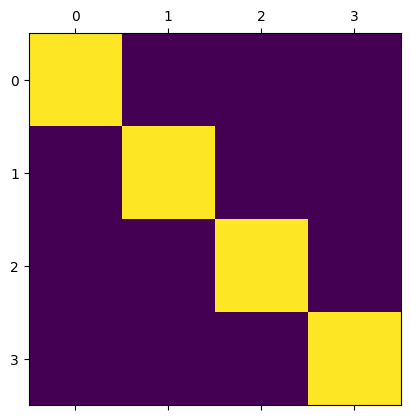

In [15]:
plt.matshow(T_ext_tsai)